# Predicting Hourly departures
Inorder for the users to utilize the city bikes, the stations need to have them available. 

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
import seaborn as sns
from lightgbm import LGBMRegressor, LGBMClassifier

# Define data paths
CLEAN_DIR = Path("../data/clean")

### Load the data

In [2]:
dtypes = {'departure_id': str, 'departure_name': str, 
            'return_id': str, 'return_name': str}
bike_df = pd.read_csv(CLEAN_DIR / 'bike_rides_cleaned.csv', dtype=dtypes, parse_dates=['departure', 'return'])
bike_df.head()

,departure,return,departure_id,departure_name,return_id,return_name,distance,duration,departure_lat,departure_lon,departure_capacity,return_lat,return_lon,return_capacity
0,2020-04-01 00:04:08,2020-04-01 00:21:27,062,Välimerenkatu,062,Välimerenkatu,999.0,17.300000,60.159296,24.916241,16.0,60.159296,24.916241,16.0
1,2020-04-01 00:12:31,2020-04-01 00:21:34,149,Toinen linja,016,Liisanpuistikko,2372.0,8.966667,60.183164,24.944195,22.0,60.174140,24.962084,17.0
2,2020-04-01 00:16:46,2020-04-01 00:46:09,118,Fleminginkatu,105,Tilkantori,4299.0,18.016667,60.188154,24.952916,22.0,60.202839,24.893476,16.0
3,2020-04-01 00:19:29,2020-04-01 00:30:13,017,Varsapuistikko,013,Merisotilaantori,1923.0,10.650000,60.173103,24.949519,28.0,60.167870,24.975534,24.0
4,2020-04-01 00:22:32,2020-04-01 00:27:29,030,Itämerentori,067,Perämiehenkatu,1376.0,4.866667,60.163531,24.914517,40.0,60.160088,24.934066,16.0


In [3]:
weather_df = pd.read_csv(CLEAN_DIR / 'weather_cleaned.csv', parse_dates=['time'], index_col='time')
weather_df.drop(columns=['precip_missing', 'ws_missing'], inplace=True)
weather_df.head()

,temperature,wind_speed,precipitation
time,,,
2020-04-01 00:00:00,2.5,6.4,0.0
2020-04-01 01:00:00,3.1,4.4,0.0
2020-04-01 02:00:00,3.3,4.1,0.0
2020-04-01 03:00:00,3.1,3.7,0.0
2020-04-01 04:00:00,3.0,4.4,0.0


### Station selection

The usage between stations differs significantly, to reduce the data and computational recources, subset of top stations is used for the predictions.

In [4]:
station_usage = (
    bike_df['departure_id']
      .value_counts()
)

In [5]:
# Define thresholds to test
thresholds = [20, 50, 100 ,150, 200, 250, 300, 350, 400, 450]

results = {}
total_rides = len(bike_df)

for t in thresholds:
    top_stations = station_usage.head(t).index
    
    # rides that belong to valid stations
    rides_kept = bike_df[bike_df['departure_id'].isin(top_stations)]
    
    results[t] = {
        "stations_kept": len(top_stations),
        "rides_kept": len(rides_kept),
        "rides_percent": round(len(rides_kept) / total_rides * 100, 2)
    }

results_df = pd.DataFrame(results).T
print(results_df)

     stations_kept  rides_kept  rides_percent
20            20.0   2488903.0          19.20
50            50.0   4802434.0          37.05
100          100.0   7501782.0          57.88
150          150.0   9351293.0          72.15
200          200.0  10610731.0          81.87
250          250.0  11442209.0          88.29
300          300.0  12045009.0          92.94
350          350.0  12473118.0          96.24
400          400.0  12777603.0          98.59
450          450.0  12942244.0          99.86


A small number of stations capture most of the rides, while many stations are rarely used. Because of the long tail in the usage, only some of the stations are used in the prediction. Top 100 stations capture nearly 60 % of the rides and gives us a good balance between data and computanional resources.

### Hourly data

In [6]:
num_stations = 100
bike_df['time'] = bike_df['departure'].dt.floor('h')
sample_bike_df = bike_df[bike_df['departure_id'].isin(station_usage.head(num_stations).index)]

bike_df_hourly = sample_bike_df.groupby(['time', 'departure_id']).size().reset_index(name='departures').rename(columns={'departure_id': 'station_id'})
# Fill in missing hours with 0 rides
season_hours = pd.date_range(start=bike_df['time'].min(), 
                      end=bike_df['time'].max(), 
                      freq='h')
season_hours = season_hours[(season_hours.month >= 4) & (season_hours.month <= 10)]
full_index = pd.MultiIndex.from_product([station_usage.head(num_stations).index, season_hours], names=['station_id', 'time'])
bike_df_hourly = (bike_df_hourly.set_index(['station_id', 'time'])).reindex(full_index, fill_value=0).reset_index()

# Add station coordinates and capacitys
station_coords = bike_df[['departure_id', 'departure_lat', 'departure_lon', 'departure_capacity']].drop_duplicates()
bike_df_hourly = bike_df_hourly.merge(station_coords, left_on='station_id', right_on='departure_id', how='left')
bike_df_hourly.drop(columns=['departure_id'], inplace=True)
bike_df_hourly.head()

,station_id,time,departures,departure_lat,departure_lon,departure_capacity
0,030,2020-04-01 00:00:00,1,60.163531,24.914517,40.0
1,030,2020-04-01 01:00:00,1,60.163531,24.914517,40.0
2,030,2020-04-01 02:00:00,0,60.163531,24.914517,40.0
3,030,2020-04-01 03:00:00,0,60.163531,24.914517,40.0
4,030,2020-04-01 04:00:00,0,60.163531,24.914517,40.0


##### Combine with the weather data

In [7]:
bike_df_hourly = bike_df_hourly.merge(weather_df, left_on='time', right_index=True, how='left')
bike_df_hourly.rename(
    columns={
        'departure_lat': 'lat',
        'departure_lon': 'lon',
        'departure_capacity': 'capacity'
    }, inplace=True)
bike_df_hourly = bike_df_hourly.drop_duplicates(subset=['station_id', 'time'])
bike_df_hourly.set_index('time', inplace=True)
bike_df_hourly.head()

,station_id,departures,lat,lon,capacity,temperature,wind_speed,precipitation
time,,,,,,,,
2020-04-01 00:00:00,030,1,60.163531,24.914517,40.0,2.5,6.4,0.0
2020-04-01 01:00:00,030,1,60.163531,24.914517,40.0,3.1,4.4,0.0
2020-04-01 02:00:00,030,0,60.163531,24.914517,40.0,3.3,4.1,0.0
2020-04-01 03:00:00,030,0,60.163531,24.914517,40.0,3.1,3.7,0.0
2020-04-01 04:00:00,030,0,60.163531,24.914517,40.0,3.0,4.4,0.0


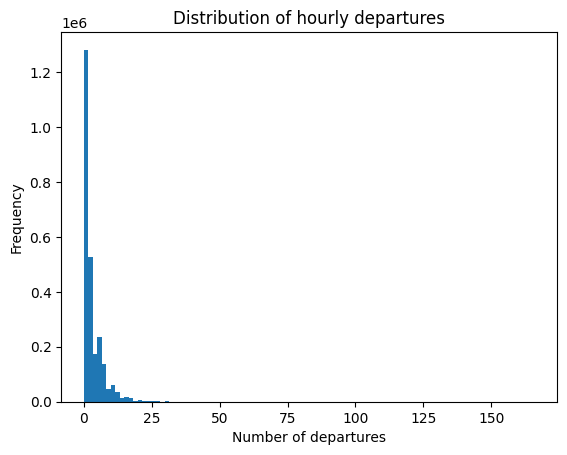

In [8]:
plt.hist(bike_df_hourly['departures'], bins=100)
plt.title('Distribution of hourly departures')
plt.xlabel('Number of departures')
plt.ylabel('Frequency')
plt.show()

The distribution shows a heavy skew, most hours have < 5 trips with zero being extermely common. Peak counts exceed 100. This requires a model that can handle zero inflated data.

### Feature Engineering

##### Temporal features
Since the data is timeseries and the data has clear seasonal trends, the following date related features are added
- hour, weekday, month, year
As weekends have different daily trends than weekdays, boolean is_weekend feature is also created.


##### Lag features
We can use domain knowledge and feature importance to decide the lags. Short term patterns, daily trends, and weekly patterns. Start with the following lags:
- Short term-lags (last three hours): lag_1. lag_2. lag_3
- Medium term-lags: lag_6, lag_12, lag_18
- Daily trends, the same hour 1,2, and 3 three days ago: lag_24, lag_48, lag_72
- Weekly cycle: lag_168
Rolling features for the same patterns:
- Rolling mean and std over 3 hour, day and week.

##### Weather features
Weather features are shifted back one hour, inorder to use the previous hours weather in the predictions. Rain is added as a boolean feature.


We can then use tree-based model for feature importance to prune unhelpful features.

In [9]:
def add_lags(group, column, freq, lags):
    group = group.sort_index()
    for lag in lags:
        group[f'{column[:3]}_lag_{lag}'] = group[column].shift(lag, freq=freq)
    return group

def add_rolling_means(group, column, freq, windows):
    group = group.sort_index()
    for window in windows:
        group[f'{column[:3]}_roll_mean_{window}'] = group[column].shift(1, freq=freq).rolling(window=window).mean()
        group[f'{column[:3]}_roll_std_{window}'] = group[column].shift(1, freq=freq).rolling(window=window).std()
    return group

def same_hour_rolling_mean(group, column, freq, windows):
    group = group.sort_index()
    dummy_group = group.copy()
    dummy_cols = []
    for i in range(1, max(windows)+1):
        dummy_col = f'{column[:3]}_same_hour_roll_mean_{i}'
        dummy_group[dummy_col] = group[column].shift(i*24, freq=freq)
        dummy_cols.append(dummy_col)
    for window in windows:
        window_cols = dummy_cols[:window]
        group[f'{column[:3]}_same_hour_mean_{window}d'] = dummy_group[window_cols].mean(axis=1)
        group[f'{column[:3]}_same_hour_std_{window}d'] = dummy_group[window_cols].std(axis=1)
    return group

def add_horizons(group, column, horizons, freq):
    group = group.sort_index()
    for h in horizons:
        group[f'{column}_t+{h}'] = group[column].shift(-h, freq=freq)
    return group

def shift_weather_cols(group, weather_cols, freq):
    group = group.sort_index()
    for col in weather_cols:
        group[col] = group[col].shift(1, freq=freq)
    return group


def make_features(df, target_col, lags, rolling_windows, same_hour_windows, weather_cols, freq):
    if df.index.name != 'time':
        df = df.set_index('time')

    df = df.groupby('station_id', group_keys=False, observed=True)[df.columns].apply(add_lags, target_col, lags=lags, freq=freq)
    
    df = df.groupby('station_id', group_keys=False, observed=True)[df.columns].apply(add_rolling_means, target_col, windows=rolling_windows, freq=freq)
    df = df.groupby('station_id', group_keys=False, observed=True)[df.columns].apply(same_hour_rolling_mean, target_col, windows=same_hour_windows, freq=freq)

    df[f'hour'] = df.index.hour
    df[f'weekday'] = df.index.weekday
    df[f'month'] = df.index.month
    df[f'is_weekend'] = df.index.weekday.isin([5, 6]).astype(int)
    df[f'year'] = df.index.year

    df['station_id'] = df['station_id'].astype('category')

    # Shift the weather columns back one block
    df = df.groupby('station_id', group_keys=False, observed=True)[df.columns].apply(shift_weather_cols, weather_cols, freq=freq)  

    df['rain'] = (df['precipitation'] > 0).astype(int)

    df = df.dropna()
    df = df.sort_values(by=['time', 'station_id'])
    df = df.reset_index(drop=False)

    return df

        

In [10]:
bike_df_with_lags = make_features(
    bike_df_hourly, 
    target_col='departures',
    lags=[1,2,3,6,12,18, 24, 48, 72, 168],
    same_hour_windows=[3,7],
    rolling_windows=[3, 24, 168],
    weather_cols=weather_df.columns,
    freq='h')
bike_df_with_lags.head()

,time,station_id,departures,lat,lon,capacity,temperature,wind_speed,precipitation,dep_lag_1,...,dep_same_hour_mean_3d,dep_same_hour_std_3d,dep_same_hour_mean_7d,dep_same_hour_std_7d,hour,weekday,month,is_weekend,year,rain
0,2020-04-08,001,1,60.155445,24.950293,30.0,7.0,8.8,0.0,0.0,...,0.666667,1.154701,0.285714,0.755929,0,2,4,0,2020,0
1,2020-04-08,003,0,60.158189,24.944927,16.0,7.0,8.8,0.0,0.0,...,0.000000,0.000000,0.142857,0.377964,0,2,4,0,2020,0
2,2020-04-08,004,2,60.160986,24.941776,14.0,7.0,8.8,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0,2,4,0,2020,0
3,2020-04-08,005,2,60.157926,24.936152,16.0,7.0,8.8,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0,2,4,0,2020,0
4,2020-04-08,006,0,60.162225,24.929710,24.0,7.0,8.8,0.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0,2,4,0,2020,0


The dataset contains five year of data, 2020-2024. 2020-2023 is used for training and 2024 for testing.

In [63]:
train = bike_df_with_lags[bike_df_with_lags.time.dt.year < 2024]
test = bike_df_with_lags[bike_df_with_lags.time.dt.year == 2024]

X_train = train.drop(["time", 'departures'], axis=1)
y_train = train['departures']
X_test = test.drop(["time", 'departures'], axis=1)
y_test = test['departures']

For crossvalidation, three splits is used. Each split uses one year as a test data, and the previous years as training data

In [12]:
ts_cv= TimeSeriesSplit(n_splits=7)
splits = list(ts_cv.split(X_train, y_train))

### Baseline: Linear Regression

Linear regression is used as a baseline model. Since model expects linearity, the cyclical time based features are encoded using sine and cosine transformation, the categorical colu

In [13]:
from sklearn.pipeline import FunctionTransformer

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [14]:
cyclical_tranformers = []
for feature, period in [('hour', 24), ('weekday', 7), ('month', 12)]:
    cyclical_tranformers.append((f'{feature}_sin', sin_transformer(period), [feature]))
    cyclical_tranformers.append((f'{feature}_cos', cos_transformer(period), [feature]))

In [15]:
from sklearn import metrics
from sklearn.metrics import make_scorer, mean_absolute_error, root_mean_squared_error, r2_score

def evaluate(model, X, y, splits):
    cv_score = cross_validate(model, X, y, cv=splits, 
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error", "r2"])
    abs_error = -cv_score["test_neg_mean_absolute_error"]
    rmse = -cv_score["test_neg_root_mean_squared_error"]
    r2 = cv_score["test_r2"]

    print(f'Mean absolute error: {abs_error.mean():.3f} +/- {abs_error.std():.3f}')
    print(f'RMSE: {rmse.mean():.3f} +/- {rmse.std():.3f}')
    print(f'R2: {r2.mean():.3f} +/- {r2.std():.3f}')

def cv_multitarget(model, X, y, splits):
    def mae_idx(y_true, y_pred, idx):
        return mean_absolute_error(y_true[:, idx], y_pred[:, idx])

    def rmse_idx(y_true, y_pred, idx):
        return root_mean_squared_error(y_true[:, idx], y_pred[:, idx])

    def r2_idx(y_true, y_pred, idx):
        return r2_score(y_true[:, idx], y_pred[:, idx])
    
    def mae_net(y_true, y_pred):
        return mean_absolute_error(y_true[:, 1] - y_true[:, 0], y_pred[:, 1] - y_pred[:, 0])
    
    def rmse_net(y_true, y_pred):
        return root_mean_squared_error(y_true[:, 1] - y_true[:, 0], y_pred[:, 1] - y_pred[:, 0])
    
    def r2_net(y_true, y_pred):
        return r2_score(y_true[:, 1] - y_true[:, 0], y_pred[:, 1] - y_pred[:, 0])

    y = y.to_numpy()

    i = 0
    scoring = {}
    for col in ['departures', 'returns']:
        scoring[f'mae_{col}'] = make_scorer(mae_idx, idx=i, greater_is_better=False)
        scoring[f'mse_{col}'] = make_scorer(rmse_idx, idx=i, greater_is_better=False)
        scoring[f'r2_{col}'] = make_scorer(r2_idx, idx=i)
        i += 1

    scoring[f'mae_net_flow'] = make_scorer(mae_idx, greater_is_better=False)
    scoring[f'mse_net_flow'] = make_scorer(rmse_idx, greater_is_better=False)
    scoring[f'r2_net_flow'] = make_scorer(r2_idx)

    cv_score = cross_validate(model, X, y, cv=splits, scoring=scoring)
    for col in ['departures', 'returns', 'net_flow']:
        abs_error = -cv_score[f'test_mae_{col}']
        rmse = -cv_score[f'test_mse_{col}']
        r2 = cv_score[f'test_r2_{col}']
        print(f"{col.capitalize()}:")
        print(f'Mean absolute error: {abs_error.mean():.3f} +/- {abs_error.std():.3f}')
        print(f'RMSE: {rmse.mean():.3f} +/- {rmse.std():.3f}')
        print(f'R2: {r2.mean():.3f} +/- {r2.std():.3f}')

def results(y_true, y_preds):
    y_true = y_true.to_numpy()
    print(f'Mean absolute error: {metrics.mean_absolute_error(y_true, y_preds):.2f}')
    print(f'RMSE: {metrics.root_mean_squared_error(y_true, y_preds):.2f}')
    print(f'R2: {metrics.r2_score(y_true, y_preds):.3f}')

def results_multitarget(y_preds, y_true):
    y_true = y_true.to_numpy()
    def smape(y_true, y_pred):
        return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

    for i, col in enumerate(['departures', 'returns']):
        print(f"{col.capitalize()}:")
        print(f'Mean absolute error: {metrics.mean_absolute_error(y_true[:, i], y_preds[:, i]):.2f}')
        print(f'RMSE: {metrics.root_mean_squared_error(y_true[:, i], y_preds[:, i]):.2f}')
        print(f'R2: {metrics.r2_score(y_true[:, i], y_preds[:, i]):.3f}')
        #print(f'SMAPE: {smape(y_true[:, i], y_preds[:, i]):.2f}%')



##### Baseline: Linear Model

The linear model requires a lot more encoding than the tree-based model. The periodical columns Day, Month, and Hour are encoded using sine and cosine transformation to two features each. The station id and cluster are encoded using one-hot encoding, the numerical columns are normalized using min-max normalization and binary features are left as 0/1.

In [55]:
features.values

array(['dep_same_hour_mean_7d', 'dep_lag_1', 'hour', 'dep_roll_mean_3',
       'dep_lag_2', 'station_id', 'temperature', 'dep_lag_24',
       'dep_lag_168', 'is_weekend', 'month', 'dep_roll_mean_24',
       'weekday', 'precipitation', 'dep_roll_std_24', 'year',
       'dep_lag_72', 'dep_same_hour_std_7d', 'dep_lag_3', 'wind_speed'],
      dtype=object)

In [61]:

numerical_features2 = [i for i in numerical_features if i in features.values]
binary_features2 = [i for i in binary_features if i in features.values]
categorical_features2 = [i for i in categorical_features if i in features.values]
categorical_features2 

['station_id']

In [64]:
lags = [i for i in X_train.columns if 'lag' in i or 'roll' in i]
numerical_features = ['year', 'precipitation', 'temperature', 'wind_speed', 'lat', 'lon', 'capacity'] + lags 
binary_features = ['is_weekend', 'rain']
categorical_features = ['station_id']


lags2 = [i for i in lags if i in features]

from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features2),
        ('bin', 'passthrough', binary_features2),
        ('cat', OneHotEncoder(), categorical_features2),
        *cyclical_tranformers
        ],
    remainder="drop",
    verbose_feature_names_out=False
)

lin_pipeline_sep = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lin_pipeline_sep.fit(X_train[features], y_train)
lin_preds = lin_pipeline_sep.predict(X_test[features])
lin_preds = np.maximum(lin_preds, 0)  # Ensure no negative predictions
results(y_test, lin_preds)

Mean absolute error: 1.53
RMSE: 2.46
R2: 0.628


In [ ]:
Mean absolute error: 1.52
RMSE: 2.44
R2: 0.632

In [17]:
baseline = (
    train.groupby(["station_id", "hour"], observed=True)["departures"].median().rename("baseline_pred")
)
test = test.merge(baseline, on=["station_id", "hour"], how="left")
results(y_test, test["baseline_pred"])

Mean absolute error: 1.82
RMSE: 3.14
R2: 0.394


In [18]:
results(y_test, test['dep_lag_1'])

Mean absolute error: 1.90
RMSE: 3.19
R2: 0.373


#### Tree based models

LightBoost regressor is used for the predictions. Since the data contains a lot of zero values, in addition to the standard regressor we also test a two-phase model, with classification model for predicting whether the value is zero or not and a regressor to predicting the magnitude of the non-zero values.

In [19]:
X_train['hour'] = X_train['hour'].astype('category')
X_train['weekday'] = X_train['weekday'].astype('category')
X_train['month'] = X_train['month'].astype('category')

X_test['hour'] = X_test['hour'].astype('category')
X_test['weekday'] = X_test['weekday'].astype('category')
X_test['month'] = X_test['month'].astype('category')


In [20]:
settings = {
    'random_state':0,
    'n_jobs':-1,
    'verbose':-1,
    'importance_type':'gain',
}

##### Regression tree

In [21]:
lgbm_model = LGBMRegressor(**settings)
evaluate(lgbm_model, X_train, y_train, splits)

Mean absolute error: 1.461 +/- 0.155
RMSE: 2.240 +/- 0.216
R2: 0.670 +/- 0.017


##### Two-phase model

In [22]:
def cv_two_phase(X, y, splits, clf_params, reg_params, features=None):
    if features is not None:
        X = X[features]
    clf = LGBMClassifier(**clf_params)
    reg = LGBMRegressor(**reg_params)
    
    scores = {
        'mae': [],
        'rmse': [],
        'r2': []
    }
    for train_idx, val_idx in splits:
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        clf.fit(X_train, (y_train > 0).astype(int))
        clf_preds = clf.predict(X_val)

        pos_ind = y_train > 0
        reg.fit(X_train[pos_ind], y_train[pos_ind])
        reg_preds = reg.predict(X_val)
        reg_preds = np.where(clf_preds == 0, 0, reg_preds)

        scores['mae'].append(mean_absolute_error(y_val, reg_preds))
        scores['rmse'].append(root_mean_squared_error(y_val, reg_preds))
        scores['r2'].append(r2_score(y_val, reg_preds))

    print(f'Mean absolute error: {np.mean(scores["mae"]):.3f} +/- {np.std(scores["mae"]):.3f}')
    print(f'RMSE: {np.mean(scores["rmse"]):.3f} +/- {np.std(scores["rmse"]):.3f}')
    print(f'R2: {np.mean(scores["r2"]):.3f} +/- {np.std(scores["r2"]):.3f}')

cv_two_phase(X_train, y_train, splits, settings, settings)

Mean absolute error: 1.487 +/- 0.155
RMSE: 2.280 +/- 0.213
R2: 0.658 +/- 0.019


##### Feature importance

SHAP is used to prune the features. To reduce computational cost, the SHAP is computed using 5000-row sample, 50 per station. 

In [23]:
import shap
X_sample = (
    X_train.groupby("station_id", observed=True)[X_train.columns]
           .apply(lambda g: g.sample(n=50, random_state=0))
           .reset_index(drop=True)
)
lgbm_model.fit(X_train, y_train)
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_sample)

shap_importance = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({
    "feature": X_sample.columns,
    "importance": shap_importance
}).sort_values("importance", ascending=False)

/home/jaakko/Desktop/Models/Citybikes/citybikes/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


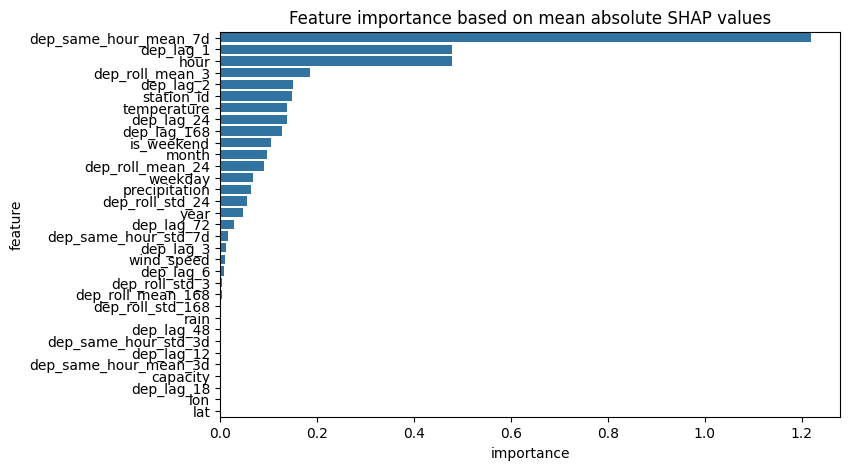

In [24]:
plt.figure(figsize=(8,5))
sns.barplot(x='importance', y='feature', data=shap_df, orient='h')
plt.title('Feature importance based on mean absolute SHAP values')
plt.show()

The graph highlights the imporatance of different feature groups for the model:

Lag features:
- The 7-day average for the same hour is the single most important feature, reflecting a strong daily pattern.
- Short term lags are also critical, `lag_1` is particularly influental, while `lag_2` and 3-hour rolling mean contribute meaningfully.
- Daily and weekly cycles are captured by `lag_24` and `lag_168`, as well as the 24-hour rolling mean and standard deviation.
- Importance decreases for the longer lags: `lag_3`, `lag_6` and `lag_72` still have moderate importance, while other lags are negligible. INterestingly `lag_72` is more important than `lag_72`, suggeting multi-day patters.

Temporal features:
- The hour of the day is the most predictive, but all temporal features contribute meaningfully to the model.

Weather features:
- Temperature is the most important weather variable, followed by precipitation.
- Wind speed has minimal impact and rain is negligible, possibly due to its rarity or because total precipitation already captures its effect.

Station characteristics:
- `station_id` carries significant predictive value, while station location and capacity contribute little.

In [25]:
features = shap_df[shap_df['importance'] > 0.01]['feature']
print(f'Selected {len(features)}, dropped {len(shap_df) - len(features)} features')
print(features.values)

Selected 20, dropped 13 features
['dep_same_hour_mean_7d' 'dep_lag_1' 'hour' 'dep_roll_mean_3' 'dep_lag_2'
 'station_id' 'temperature' 'dep_lag_24' 'dep_lag_168' 'is_weekend'
 'month' 'dep_roll_mean_24' 'weekday' 'precipitation' 'dep_roll_std_24'
 'year' 'dep_lag_72' 'dep_same_hour_std_7d' 'dep_lag_3' 'wind_speed']


In [26]:
evaluate(lgbm_model, X_train[features], y_train, splits)

Mean absolute error: 1.462 +/- 0.155
RMSE: 2.240 +/- 0.215
R2: 0.670 +/- 0.017


In [27]:
cv_two_phase(X_train, y_train, splits, settings, settings, features)

Mean absolute error: 1.486 +/- 0.154
RMSE: 2.279 +/- 0.213
R2: 0.658 +/- 0.019


To simplify the model and focus on meaningful predictors, we dropped features with mean absolute SHAP values below 0.01. This removed negligible features without affecting predictive performance.

### Hyperparameter tuning using Bayes Search
Mean Average error is used for tuning the regression models, and F1-score for tuning the classification model.

In [356]:
from hyperopt import STATUS_OK,fmin, tpe, hp
def objective_reg(params, X, y, splits, single=True):
    params["num_leaves"] = int(params["num_leaves"])
    params["n_estimators"] = int(params["n_estimators"])
    params["max_depth"] = int(params["max_depth"])
    params["min_child_samples"] = int(params["min_child_samples"])
    
    reg = LGBMRegressor(**params)
    scores = []
    for train_idx, val_idx in splits:
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        if single:
            reg.fit(X_train, y_train)
            preds = reg.predict(X_val)
            scores.append(mean_absolute_error(y_val, preds))
        else:
            pos_ind = y_train > 0
            reg.fit(X_train[pos_ind], y_train[pos_ind])
            preds = reg.predict(X_val)
            scores.append(mean_absolute_error(y_val[y_val > 0], preds[y_val > 0]))
    return {'loss': np.mean(scores), 'status': STATUS_OK}

In [348]:
from sklearn.metrics import f1_score
def objective_clf(params, X, y, splits):
    params["num_leaves"] = int(params["num_leaves"])
    params["n_estimators"] = int(params["n_estimators"])
    params["max_depth"] = int(params["max_depth"])
    params["min_child_samples"] = int(params["min_child_samples"])
    
    clf = LGBMClassifier(**params)
    cv_scores = cross_val_score(clf, X, y, cv=splits, scoring='f1')

    return {'loss': -cv_scores.mean(), 'status': STATUS_OK}

In [349]:

# Define the hyperparameter space
space = {
    "num_leaves": hp.quniform("num_leaves", 20, 150, 1),
    "n_estimators": hp.quniform('n_estimators', 100, 500, 25),
    "max_depth": hp.quniform("max_depth", 3, 15, 1),
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),
    "feature_fraction": hp.uniform("feature_fraction", 0.5, 1.0),
    "col_sample_bytree": hp.uniform("col_sample_bytree", 0.5, 1.0),
    "subsample": hp.uniform("subsample", 0.5, 1.0),
    "min_child_samples": hp.quniform("min_child_samples", 5, 50, 1),
    **settings
}

best_params_single = fmin(fn=lambda p: objective_reg(p, X_train[features], y_train, splits), space=space, algo=tpe.suggest, max_evals=30)
best_params_reg = fmin(fn=lambda p: objective_reg(p, X_train[features], y_train, splits, single=False), space=space, algo=tpe.suggest, max_evals=30)
best_params_clf = fmin(fn=lambda p: objective_clf(p, X_train[features], (y_train > 0).astype(int), splits), space=space, algo=tpe.suggest, max_evals=30)

100%|██████████| 30/30 [14:54<00:00, 29.80s/trial, best loss: -0.8834881440294549]


In [28]:
best_params_single = {'col_sample_bytree': np.float64(0.675120733757147),
 'feature_fraction': np.float64(0.8365151836130118),
 'learning_rate': np.float64(0.031872296301578826),
 'max_depth': 10,
 'min_child_samples': 49,
 'n_estimators': 500,
 'num_leaves': 142,
 'subsample': np.float64(0.5366691919797824)}

In [29]:
best_params_reg = {'col_sample_bytree': np.float64(0.5415076645557563),
 'feature_fraction': np.float64(0.7033980318409198),
 'learning_rate': np.float64(0.03216344745058156),
 'max_depth': 14,
 'min_child_samples': 25,
 'n_estimators': 425,
 'num_leaves': 111,
 'subsample': np.float64(0.5632477360343565)}

In [30]:
best_params_clf = {'col_sample_bytree': np.float64(0.6891239377305969),
 'feature_fraction': np.float64(0.5622451029297888),
 'learning_rate': np.float64(0.03811147127022968),
 'max_depth': 13,
 'min_child_samples': 42,
 'n_estimators': 325,
 'num_leaves': 111,
 'subsample': np.float64(0.8589674109669201)}

In [31]:
for param in ["num_leaves", "n_estimators", "max_depth", "min_child_samples"]:
    best_params_single[param] = int(best_params_single[param])
    best_params_reg[param] = int(best_params_reg[param])
    best_params_clf[param] = int(best_params_clf[param])

In [32]:
lgbm_model_single = LGBMRegressor(**best_params_single)
evaluate(lgbm_model_single, X_train[features], y_train, splits)

Mean absolute error: 1.444 +/- 0.158
RMSE: 2.216 +/- 0.219
R2: 0.678 +/- 0.014


In [33]:
cv_two_phase(X_train[features], y_train, splits, best_params_clf, best_params_single, features)

Mean absolute error: 1.476 +/- 0.159
RMSE: 2.261 +/- 0.218
R2: 0.664 +/- 0.016


<table>
  <tr>
    <th rowspan="2">Result</th>
    <th colspan="3">Single</th>
    <th colspan="3">Two phase</th>
  </tr>
  <tr>
    <th>MAE</th>
    <th>RMSE</th>
    <th>R2</th>
    <th>MAE</th>
    <th>RMSE</th>
    <th>R2</th>
  </tr>
  <tr>
    <td>Default settings</td>
    <td>4.730 +/- 0.332</td>
    <td>7.088 +/- 0.570</td>
    <td>0.842 +/- 0.003</td>
    <td>3.692 +/- 0.256</td>
    <td>5.783 +/- 0.418</td>
    <td>0.831 +/- 0.003</td>
  </tr>
  <tr>
    <td>Hyperparameter tuning</td>
    <td>4.572 +/- 0.291</td>
    <td>6.839 +/- 0.477</td>
    <td>0.853 +/- 0.001</td>
    <td>3.516 +/- 0.232</td>
    <td>5.521 +/- 0.357</td>
    <td>0.846 +/- 0.002</td>
  </tr>
</table>

Hyperparameter tuning provided a small improvement over the default LightGBM settings. LightGBM generally performs well out-of-the-box, so the gains from tuning were marginal, but still noticeable in slightly better predictive accuracy.


#### Results
The linear model was trained using all features, whereas the LightGBM models were trained using the selected features and tuned hyperparameters.

##### Linear

In [34]:
results(y_test, lin_preds)

Mean absolute error: 1.52
RMSE: 2.44
R2: 0.632


##### XGBoost

In [35]:
lgbm_model = LGBMRegressor(**settings, **best_params_single)
lgbm_preds = lgbm_model.fit(X_train[features], y_train).predict(X_test[features])
results(y_test, lgbm_preds)

Mean absolute error: 1.38
RMSE: 2.21
R2: 0.699


In [36]:
lgbm_model_reg = LGBMRegressor(**settings, **best_params_reg)
pos_inds = y_train > 0
lgbm_preds_reg = lgbm_model_reg.fit(X_train[features][pos_inds], y_train[pos_inds]).predict(X_test[features])
lgbm_model_clf = LGBMClassifier(**settings, **best_params_clf)
lgbm_clf_preds = lgbm_model_clf.fit(X_train[features], (y_train > 0).astype(int)).predict(X_test[features])
two_phase_preds = np.where(lgbm_clf_preds == 0, 0, lgbm_preds_reg)
results(y_test, two_phase_preds)

Mean absolute error: 1.42
RMSE: 2.26
R2: 0.687


##### Regression metrics

| Model               | MAE  | RMSE | $R^2$ |
| ------------------- | ---- | ---- | ----- |
| Linear Regression   | 1.52 | 2.44 | 0.632 |
| LightGBM Regression | 1.38 | 2.21 | 0.699 |
| LightGBM Two-Phase  | 1.42 | 2.26 | 0.687 |

- Both LightGBM models clearly outperform the baseline linear regression.
    - For the LightGBM regression model:
        - MAE decreases by 0.14 ( \approx 10.1 \%)
        - RMSE decreases by 0.22 ( \approx 10.4 \%)
        - MAE decreases by 0.067 ( \approx 9.6 \%)
- The LightGBM regression model slightly outperforms the two-phase model across all metrics.
        - MAE decreases by 0.04 ( \approx 2.9 \%)
        - RMSE decreases by 0.05 ( \approx 2.3 \%)
        - MAE decreases by 0.012 ( \approx 1.7 \%)
    - In the two-phase model, the classification misclassifications can introduce additional error.

##### Classification metrics for the Two-Phase model

              precision    recall  f1-score   support

           0     0.7977    0.7125    0.7527    171407
           1     0.8566    0.9048    0.8800    325393

    accuracy                         0.8385    496800
   macro avg     0.8271    0.8087    0.8164    496800
weighted avg     0.8363    0.8385    0.8361    496800



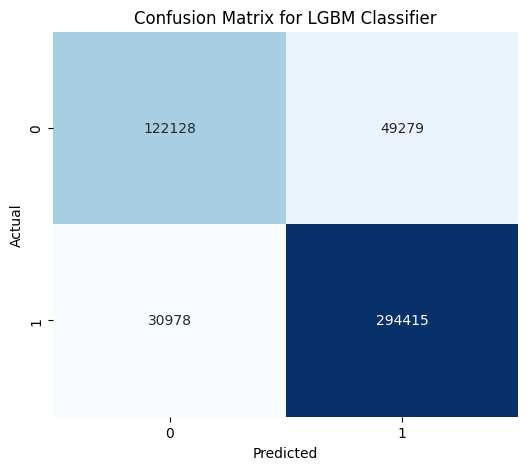

In [37]:
from sklearn.metrics import confusion_matrix, classification_report
y_test_clf = (y_test > 0).astype(int)
print(classification_report(y_test_clf, lgbm_clf_preds, digits=4))
cm = confusion_matrix(y_test_clf, lgbm_clf_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for LGBM Classifier')
plt.show()

The model predicts non-zero departures better than zero departures.
- Recall for class 1 is high (0.905), but lower for class 0 (0.713), indicating a significant number false zero predictions.
- The false negatives for zero departures can be detrimental in the classification stage, if a zero is misclassified, the regression stage predicts a non-zero value, increasing error.
- This explains why the two-phase model slightly underperforms the regression model, despite high F1-scores and overall accuracy.

##### Visualizing results


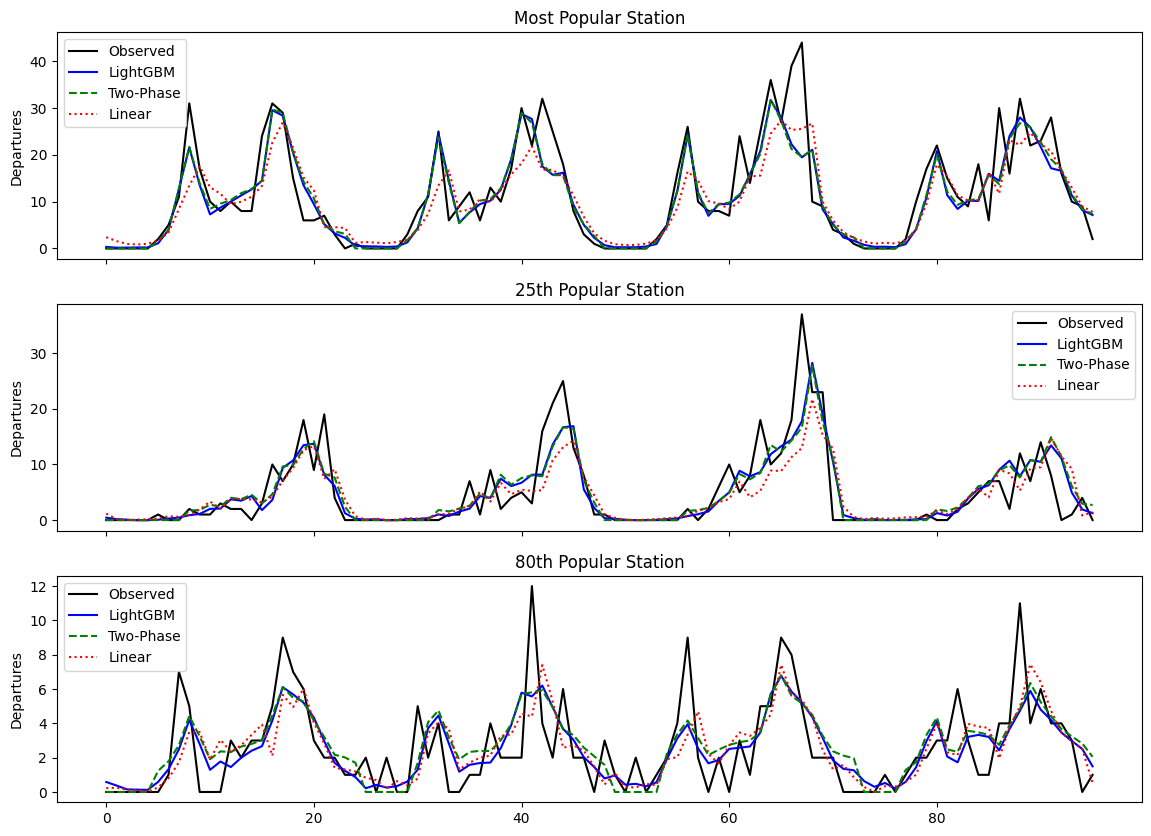

In [74]:
# 3 stations with different amount of usage
stations = top_stations[[1,25,80]]
indices = []
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
for station in stations:
    indices.append(X_test[X_test['station_id'] == station].index)

start_ind = 24*120
stations = ["Most Popular", "25th Popular", "80th Popular"]
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

for i, ax in enumerate(axes):
    index = indices[i]
    ind = index[start_ind: start_ind + 4*24]
    ax.plot(y_test[ind ].to_numpy(), label="Observed", color="black")
    ax.plot(lgbm_preds[ind], label="LightGBM", color="blue")
    ax.plot(two_phase_preds[ind], label="Two-Phase", color="green", linestyle="--")
    ax.plot(lin_preds[ind], label="Linear", color="red", linestyle=":")
    ax.set_title(f"{stations[i]} Station")
    ax.set_ylabel("Departures")
    ax.legend()
#for i in range(len(stations)):
#    index = indices[i]
#    ind = index[start_ind: start_ind + 4*24]
#    ax[i].plot(
#        y_test[ind ].to_numpy(),
#        label='Observations',
#    )
#    ax[i].plot(
#        lgbm_preds[ind],
#        label='LGBM regression',
#    )
#    ax[i].plot(
#        two_phase_preds[ind],
#        label='LGBM two-phase',
#    )
#    ax[i].plot(
#        lin_preds[ind],
#        label='Linear',
#    )
#    _ = ax[i].legend()

##### Weekly observations vs Predictions
The graph shows one week of observed and predicted departures in the middle of the city bike season for three stations: the most popular, the 20th most popular, and the 80th most popular.

Key Observations:
- LightGBM models:
    - Predictions from the statndard regression and the two-phase model are almost identical.
- Most poplar station:
    - LightGBM models capture the daily cycle well ,with relatively small errors.
    - The largest peaks are slightly underesimated.
    - Linear regression performs worse, although it captures the daily cycle well, it tends to  overestimate the demand during the night.
- 20th most popular station:
    - All models underestimate the peak usage, but the LightGBM predictions are closer to the observed values than the linear model.
- 80th most popular station:
    - As departure counts decrease and hourly variability increases, LightGBM models have more difficulties predicting the exact values.
    - Predictions follow the daily cycle, but sudden drops and spikes are often missed.

Takeaway:
- LightGBM models perform well, particularly for high-volume stations.
- Perdiction accuracy decreases for the lower-volume stations.
- Linear regression captures general trends but struggles with night-time low demand and peak prediction.

The LightGBM models have almost identical results on the graphs. The two-phase model seems to be slightly better at the zero departures, but otherwise the difference is marginal. 

For the most popular station, the lightGBM models manages to predict the peaks and valleys pretty well, and the errors are quite small. They miss the largest peaks slightly. The linear model preforms worse, although it captures the daily cycle quite well it seems to overestimate the demand during the night when the demand is lowest.

For the 20th most popular station, the all the models underestimate the peak usage, although the lGBM models are closer than the linear model.

For the last station, we can see as the values get smaller and hourly variation increases, the lightGBM modes have more troubles predicting the values. The predictions follow the daily cycle quite well, but it fails to predict the sudden drops and increases in the departures.

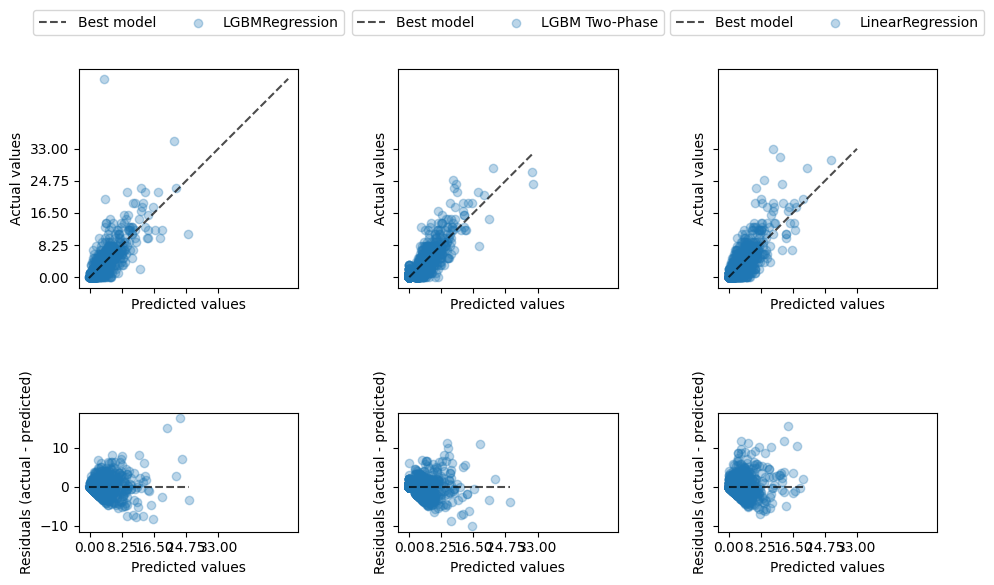

In [67]:
from sklearn.metrics import PredictionErrorDisplay

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 7), sharex=True, sharey="row")

plot_kinds = ["actual_vs_predicted", "residual_vs_predicted"]
labels = ['LGBMRegression', 'LGBM Two-Phase', 'LinearRegression']

for axis_idx, kind in enumerate(plot_kinds):
    for ax, pred, label in zip(axes[axis_idx], [lgbm_preds, two_phase_preds, lin_preds], labels):
        disp = PredictionErrorDisplay.from_predictions(
            y_true=y_test,
            y_pred=pred,
            kind=kind,
            scatter_kwargs={"alpha": 0.3},
            ax=ax,
        )
        #ax.set_xticks(np.linspace(0, 60, num=5))
        if axis_idx == 0:
            #ax.set_yticks(np.linspace(0, 60, num=5))
            ax.legend(
                ["Best model", label],
                loc="upper center",
                bbox_to_anchor=(0.5, 1.3),
                ncol=2,
            )
        ax.set_aspect("equal", adjustable="box")
plt.tight_layout()
plt.show()


The residuals show that 

### Simulation

### SUMMARY